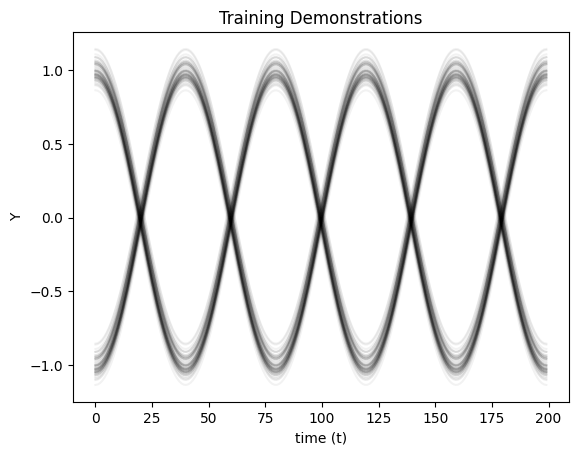

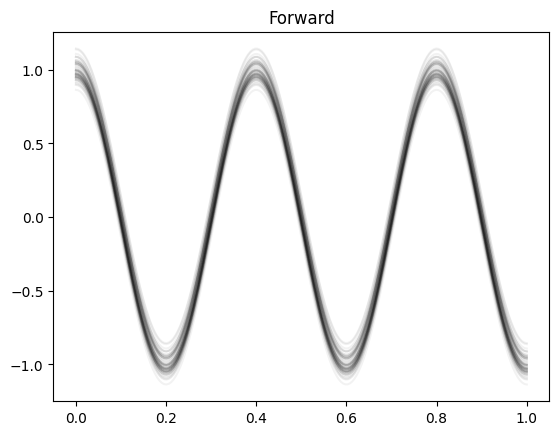

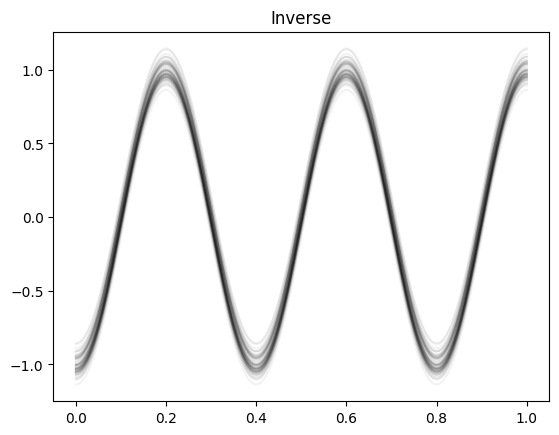

In [101]:
from cProfile import label
from re import X
from turtle import color
from sympy import li
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
import importlib

import dual_enc_dec_cnmp
import utils
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

#params = np.array([[2,0],[2,0],[2,0],[2,0],[2,0],[-0.6,0.1],[-0.55, 0.16],[-0.5,0.23],[-0.45, 0.33],[-0.4,0.43]])
params = np.array([[20],[19.9],[19.7]])
validation_indices = [i+1 for i in range(0, 128, 8)]

X1, X2, Y1, Y2, validation_Y1, validation_Y2 = utils.generate_demonstrations(time_len=200, params = params, plot_title='Training')

In [112]:
demo_data = [X1, X2, Y1, Y2]
d_x = 1
d_y1 = 1
d_y2 = 1
OBS_MAX = 10
d_N = Y1.shape[0]
time_len = 200

#validation_idx = validation_indices[0]


model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2).double()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40000, gamma=0.1)

#target_demo = Y2[validation_idx]
#target_demo = torch.from_numpy(target_demo.copy()).double()

errors = []
losses = []
#best_mean = torch.zeros(0)
#best_std = torch.zeros(0)

#condition_points = [[0.0, Y1[validation_idx, :1]], [1.0, Y1[validation_idx, -1:]]]

EPOCHS = 200000

In [113]:
for i in range(EPOCHS):

    obs, x_tar, y_tar = dual_enc_dec_cnmp.get_training_sample(validation_indices, X1, Y1, X2, Y2, OBS_MAX, d_N, d_x, d_y1, d_y2, time_len)

    optimizer.zero_grad()

    output = model(obs, x_tar)
    loss = dual_enc_dec_cnmp.log_prob_loss(output, y_tar, d_y1)

    loss.backward()
    #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.5)
    optimizer.step()
    #scheduler.step()
    # print(optimizer.param_groups[0]['lr'])

    if i % 100 == 0:
        if i % 1000 == 0:
            print(f'Epoch: {i}, Loss: {loss.item()}')
            error = 0
            for validation_idx in validation_indices:
                condition_points = [[0.0, Y1[validation_idx, :1]], [1.0, Y1[validation_idx, -1:]]]
                means, stds = dual_enc_dec_cnmp.predict_inverse(model, validation_idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
                if i % 10000 == 0 and validation_idx == validation_indices[5]:
                    error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=True)
                else:
                    error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=False)
            errors.append(error)
            if error == min(errors):
                print('Saving model ', i)
                torch.save(model.state_dict(), 'inverse_best_model.pth')
            """
            losses.append(loss.item())
            if loss.item() == min(losses):
                print('Saving model ', i)
                torch.save(model.state_dict(), 'inverse_best_model.pth')
            """
            continue
        losses.append(loss.item())
        """
        if loss.item() == min(losses):
            print('Saving model ', i)
            torch.save(model.state_dict(), 'inverse_best_model.pth')
        """
    

Epoch: 0, Loss: 3.2963514204943385
Saving model  0
Saving model  100
Saving model  200
Saving model  400
Saving model  700
Saving model  800
Saving model  900
Epoch: 1000, Loss: 2.8699497792431843
Saving model  1100
Saving model  1300
Epoch: 2000, Loss: 1.8113612790168
Epoch: 3000, Loss: 1.200912140942156
Epoch: 4000, Loss: 2.497046103990977
Saving model  4300
Epoch: 5000, Loss: 3.2667207333429165
Saving model  5200
Epoch: 6000, Loss: 3.0440345407421177
Epoch: 7000, Loss: 1.1679008593520597
Saving model  7800
Epoch: 8000, Loss: 1.0978325514841056
Saving model  8900
Epoch: 9000, Loss: -1.3428380391317736
Saving model  9000
Epoch: 10000, Loss: -1.59549415238057
Saving model  10000
Saving model  10700
Epoch: 11000, Loss: 1.3143152290118254
Epoch: 12000, Loss: -1.8428977622179112
Saving model  12800
Saving model  12900
Epoch: 13000, Loss: 1.1768127271246258
Epoch: 14000, Loss: 1.605568875725925
Epoch: 15000, Loss: 1.8579383893897494
Epoch: 16000, Loss: -2.390401222587799
Epoch: 17000, Loss

/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_7987/1903253375.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('inverse

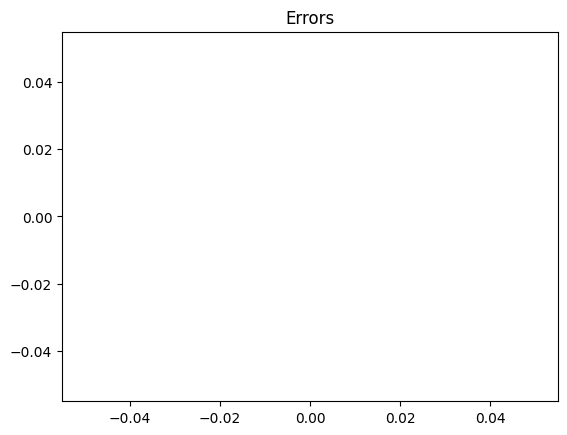

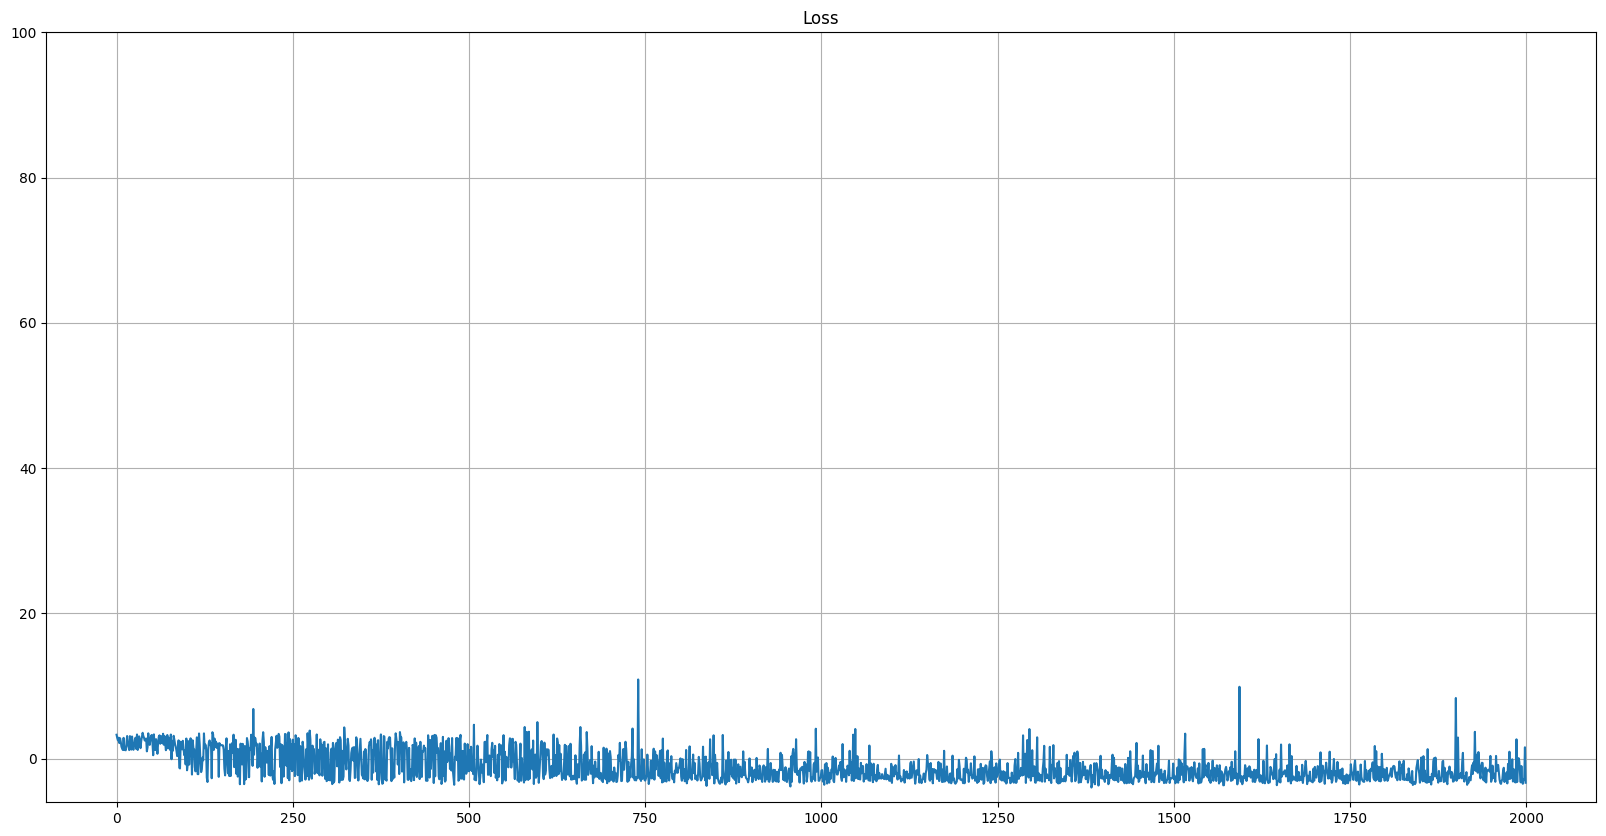

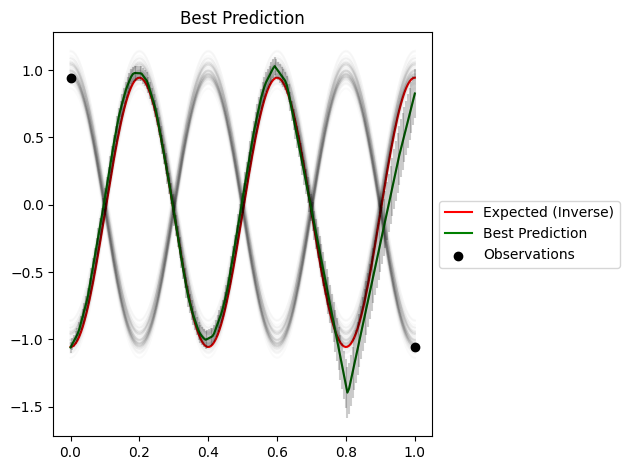

In [114]:

best_model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2).double()
best_model.load_state_dict(torch.load('inverse_best_model.pth'))

idx = 5
condition_points = [[0.0, Y1[idx, :1]], [1.0, Y1[idx, -1:]]]
means, stds = dual_enc_dec_cnmp.predict_inverse(best_model, idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
utils.plot_results(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N)